In [1]:
import jax.numpy as jnp
from jax import jit, random, lax
import numpy as np
import matplotlib.pyplot as plt

import randgen
import jax
from utils import timeit

In [2]:
seed = 980906
batch_size = int(1e5)
key = random.PRNGKey(seed)
key, seed = random.split(key)

# Random generator test

In [3]:
@timeit
def test_binomial(size=int(1e3)):
    seed = 980906
    key = random.PRNGKey(seed)
    key, seed = random.split(key)
    p = random.uniform(seed, shape=(size,), minval=0., maxval=1.)
    key, seed = random.split(key)
    n = random.uniform(seed, shape=(size,), minval=0., maxval=1000).astype(np.int32)
    return randgen.binomial(key, p, n)

In [5]:
# binomial
n = jnp.array([[100, 100, 100, 100]])
# n = 1000
p = jnp.array([[1.0], [0.3], [0.4], [0.5]])
key, rvs = randgen.binomial(key, p, n)
print(rvs)

[[100 100 100 100]
 [ 37  38  22  35]
 [ 38  42  41  43]
 [ 48  49  51  45]]


In [5]:
# poisson
lam = jnp.array([10., 100., 1000., 10000.])
key, rvs = randgen.poisson(key, lam)
print(rvs)

[   9  124 1009 9973]


In [6]:
# normal
mean = jnp.array([[10., 100., 1000., 10000.]])
std = jnp.array([[1.], [10.], [100.]])
key, rvs = randgen.normal(key, mean, std)
print(rvs)

[[ 8.66291904e+00  9.91497574e+01  1.00068951e+03  9.99813281e+03]
 [ 6.93036461e+00  1.04591446e+02  9.86729004e+02  9.99289062e+03]
 [-5.73304672e+01 -2.60337830e+00  1.10003906e+03  1.00881377e+04]]


In [19]:
# truncated normal
mean = jnp.array([[10., 100., 1000., 10000.]])
std = jnp.array([[1.], [10.], [100.]])
vmin = 0
key, rvs = randgen.truncate_normal(key, mean, std, vmin=vmin)
print(rvs)

[[1.04218493e+01 1.00314392e+02 9.98710632e+02 9.99876562e+03]
 [3.99787903e+00 9.63215103e+01 1.00124866e+03 1.00012979e+04]
 [1.12429642e+02 3.18030884e+02 1.04280188e+03 1.01218506e+04]]


# Quanta generator

In [6]:
field = 23.

w = 13.7e-3
fano = 0.059
ex_ion_ratio = 0.12

gamma = 0.107
omega = 36.6
delta = -0.224
q0 = -0.490
q1 = 1.34
q2 = 0.0284
q3 = 15.75

g1 = 0.15
g2 = 16.

p_dpe = 0.21
spe_spread = 0.2

In [7]:
def get_num_quanta(key, energy):
    num_quanta_mean = energy / w
    num_quanta_std = jnp.sqrt(num_quanta_mean * fano)
    key, num_quanta = randgen.truncate_normal(key, num_quanta_mean, num_quanta_std, vmin=0)
    
    return key, num_quanta.round().astype(np.int32)

In [8]:
def get_num_ion(key, num_quanta):
    p_ion = 1. / (1. + ex_ion_ratio)
    key, num_ion = randgen.binomial(key, p_ion, num_quanta)
    
    return key, num_ion

In [9]:
def get_mean_mTI_recomb(energy):
    ni = energy / w / (1. + ex_ion_ratio)
    ti = ni * gamma * jnp.exp(- energy / omega) * field**delta / 4.
    fd = 1. / (1. + jnp.exp(- (energy - q0) / q1))
    r = jnp.where(
        ti < 1e-2, 
        ti / 2. - ti * ti / 3., 
        1. - jnp.log(1. + ti) / ti
    )
    return r * fd

In [10]:
def get_std_recomb(energy):
    return jnp.clip(q2 * (1. - jnp.exp(- energy / q3)), 0, 1.)

In [11]:
def get_true_recomb(key, r_mean, r_std):
    return randgen.truncate_normal(key, r_mean, r_std, vmin=0., vmax=1.)

In [12]:
def get_num_electron(key, num_ion, r_true):
    p_not_recomb = 1. - r_true
    return randgen.binomial(key, p_not_recomb, num_ion)

In [13]:
def get_naive_cs1(key, num_photon):
    key, nphd = randgen.binomial(key, g1, num_photon)
    key, ndpe = randgen.binomial(key, p_dpe, nphd)
    nphr = nphd + ndpe
    
    return randgen.truncate_normal(key, nphr, jnp.sqrt(nphr)*spe_spread, vmin=0.)

In [14]:
def get_naive_cs2(key, num_electron):
    mean_cs2 = num_electron * g2
    return randgen.truncate_normal(key, mean_cs2, jnp.sqrt(mean_cs2), vmin=0.)

In [15]:
@timeit
@jit
def sim(key, energy):
    num_quanta_mean = energy / w
    num_quanta_std = jnp.sqrt(num_quanta_mean * fano)
    key, num_quanta = randgen.truncate_normal(key, num_quanta_mean, num_quanta_std, vmin=0)
    
    p_ion = 1. / (1. + ex_ion_ratio)
    key, num_ion = randgen.binomial(key, p_ion, num_quanta)
    
    ni = energy / w / (1. + ex_ion_ratio)
    ti = ni * gamma * jnp.exp(- energy / omega) * field**delta / 4.
    fd = 1. / (1. + jnp.exp(- (energy - q0) / q1))
    r = jnp.where(
        ti < 1e-2, 
        ti / 2. - ti * ti / 3., 
        1. - jnp.log(1. + ti) / ti
    )
    r_mean = r * fd
    r_std = jnp.clip(q2 * (1. - jnp.exp(- energy / q3)), 0, 1.)
    key, r_true = randgen.truncate_normal(key, r_mean, r_std, vmin=0., vmax=1.)
    
    p_not_recomb = 1. - r_true
    key, num_electron = randgen.binomial(key, p_not_recomb, num_ion)
    num_photon = num_quanta - num_electron
    
    return key, num_photon, num_electron

In [16]:
@timeit
@jit
def sim(key, energy):
    key, num_quanta = get_num_quanta(key, energy)
    p_ion = 1. / (1. + ex_ion_ratio)
    q_ion = 1. - p_ion
    print(jnp.all((num_quanta*p_ion>5) & (num_quanta*q_ion>5)))
    key, num_ion = get_num_ion(key, num_quanta)
    
    r_mean = get_mean_mTI_recomb(energy)
    r_std = get_std_recomb(energy)
    key, r_true = get_true_recomb(key, r_mean, r_std)
    
    key, num_electron = get_num_electron(key, num_ion, r_true)
    num_photon = num_quanta - num_electron
    
    key, cs1 = get_naive_cs1(key, num_photon)
    key, cs2 = get_naive_cs2(key, num_photon)
    
    return key, cs1, cs2

In [17]:
# cache
size = int(1e6)
key, seed = random.split(key)
energy = random.uniform(seed, shape=(size,), minval=5, maxval=10.)
key, cs1, cs2 = sim(key, energy)

 Function <sim> starts. 
Traced<ShapedArray(bool[])>with<DynamicJaxprTrace(level=0/1)>
 Function <sim> ends! Time cost = 0.982024 sec. 


In [20]:
key, seed = random.split(key)
energy = random.uniform(seed, shape=(size,), minval=0.01, maxval=10.)
key, cs1, cs2 = sim(key, energy)

 Function <sim> starts. 
 Function <sim> ends! Time cost = 0.000593 sec. 


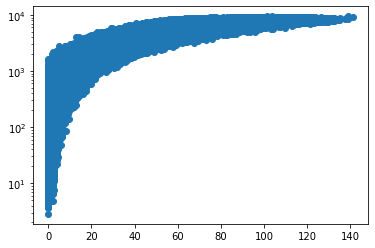

In [ ]:
plt.scatter(cs1, cs2)
plt.yscale('log')